In [1]:
# Combine all parquet files in a directory into a single parquet file

import os
import sys
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

def combine_parquet_files(input_dir, output_file):
    # Get list of all parquet files in the input directory
    input_files = [f for f in os.listdir(input_dir) if f.endswith('.parquet')]
    if len(input_files) == 0:
        print('No parquet files found in input directory')
        sys.exit(1)

    # Read all parquet files into a single table
    tables = [pq.read_table(os.path.join(input_dir, f)) for f in input_files]
    table = pa.concat_tables(tables)

    # Write the combined table to a new parquet file
    pq.write_table(table, output_file)

In [ ]:
combine_parquet_files('../../../comments', 'comments.parquet')

In [ ]:
combine_parquet_files('../../../submissions', 'submissions.parquet')

In [41]:
submissions = pd.read_csv('df_ml.csv')

In [51]:
comments = pd.read_parquet('comments.parquet')

In [52]:
# Get count and avg score of submissions for each subreddit, avg comments
submissions = submissions[submissions['subreddit'] != 'GreenParty']
submissions = submissions[submissions['subreddit'] != 'Ask_Politics']
submissions = submissions[submissions['subreddit'] != 'PoliticalDiscussion']
submissions.groupby('subreddit').agg(
    count=('score', 'count'),
    avg_score=('score', 'mean'),
    avg_comments=('num_comments', 'mean')
).to_csv('subreddit_table.csv')


In [53]:
comments['stripped_link_id'] = comments['link_id'].str.replace('t3_', '')
filtered_comments = comments[comments['stripped_link_id'].isin(submissions['id'])]

In [55]:
submissions.to_parquet('submissions_final.parquet')
filtered_comments.to_parquet('comments_final.parquet')

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
# Get monthly averages of controversiality and score for each subreddit
comments['created_utc'] = pd.to_datetime(comments['created_utc'], unit='s')
comments['month'] = comments['created_utc'].dt.to_period('M')
comments['year'] = comments['created_utc'].dt.to_period('Y')
comments['day'] = comments['created_utc'].dt.to_period('D')

# Convert score to standard normal distribution by subreddit
comments['norm_score'] = comments.groupby('subreddit')['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)
# Convert score to standard normal distribution overall
comments['norm_score2'] = (comments['score'] - comments['score'].mean()) / comments['score'].std()

monthly_avg = comments.groupby(['subreddit', 'year', 'month']).agg(
    avg_controversiality=('controversiality', 'mean'),
    avg_score=('norm_score', 'mean'),
    avg_score2=('norm_score2', 'mean'),
    avg_score_raw=('score', 'mean')
).reset_index()

In [61]:
monthly_avg

,subreddit,year,month,avg_controversiality,avg_score,avg_score2,avg_score_raw
0,Conservative,2023,2023-06,0.067283,0.047315,-0.006249,9.284321
1,Conservative,2023,2023-07,0.021443,-0.079793,-0.055119,4.094242
2,Conservative,2023,2023-08,0.000044,-0.155522,-0.084235,1.002110
3,Conservative,2023,2023-09,0.000044,-0.155558,-0.084249,1.000629
4,Conservative,2023,2023-10,0.000624,-0.154049,-0.083669,1.062255
...,...,...,...,...,...,...,...
79,politics,2024,2024-03,0.033276,0.033863,0.045399,14.769317
80,politics,2024,2024-04,0.041448,0.035865,0.047621,15.005338
81,politics,2024,2024-05,0.043401,0.031570,0.042854,14.499056
82,politics,2024,2024-06,0.045070,0.016874,0.026542,12.766751


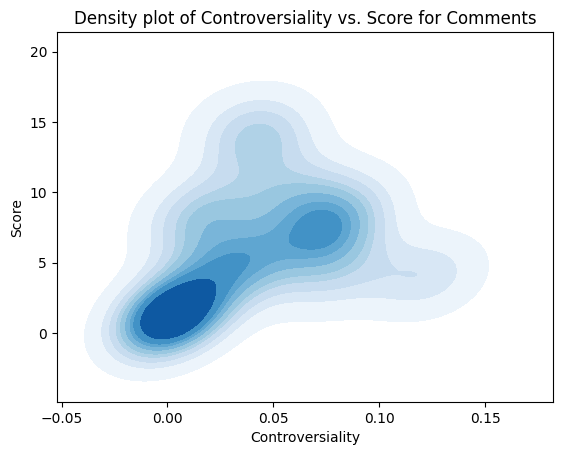

In [62]:
sns.kdeplot(data=monthly_avg, x='avg_controversiality', y='avg_score_raw', fill=True, cmap='Blues', levels=10)
plt.xlabel('Controversiality')
plt.ylabel('Score')
plt.title('Density plot of Controversiality vs. Score for Comments')
plt.show()

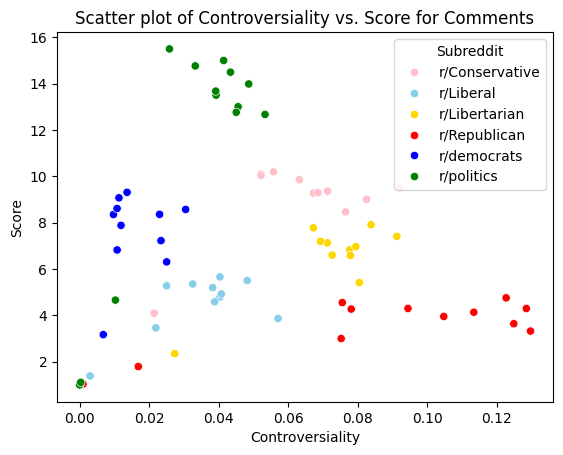

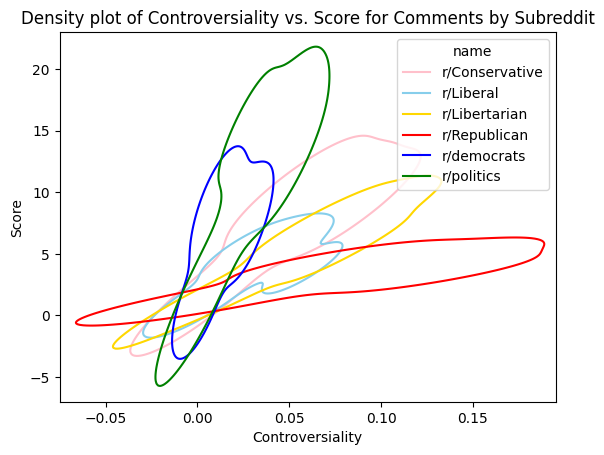

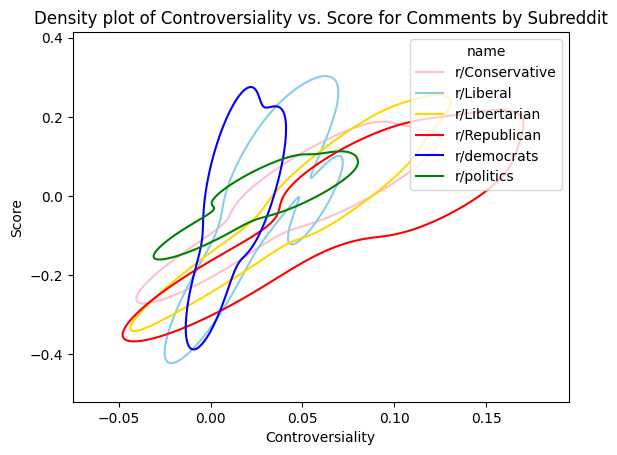

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

color_map = {
    "r/Conservative": "pink",
    "r/Republican": "red",
    "r/democrats": "blue",
    "r/Liberal": "skyblue",
    "r/Libertarian": "gold",
    "r/politics": "green"
}
# change from name to r/name
monthly_avg['name'] = 'r/' + monthly_avg['subreddit']

sns.scatterplot(
    data=monthly_avg,
    x='avg_controversiality',
    y='avg_score_raw',
    hue='name',
    palette=color_map
)
plt.xlabel('Controversiality')
plt.ylabel('Score')
plt.legend(title='Subreddit')
plt.title('Scatter plot of Controversiality vs. Score for Comments')
plt.show()

sns.kdeplot(
    data=monthly_avg,
    x='avg_controversiality',
    y='avg_score_raw',
    hue='name',
    palette=color_map,
    levels=2
)
plt.xlabel('Controversiality')
plt.ylabel('Score')
plt.xlim(-0.075, 0.195)
plt.ylim(-7, 23)
plt.title('Density plot of Controversiality vs. Score for Comments by Subreddit')
plt.show()

sns.kdeplot(
    data=monthly_avg,
    x='avg_controversiality',
    y='avg_score',
    hue='name',
    palette=color_map,
    levels=2
)
plt.xlabel('Controversiality')
plt.ylabel('Score')
plt.xlim(-0.075, 0.195)
# plt.ylim(-7, 23)
plt.title('Density plot of Controversiality vs. Score for Comments by Subreddit')
plt.show()

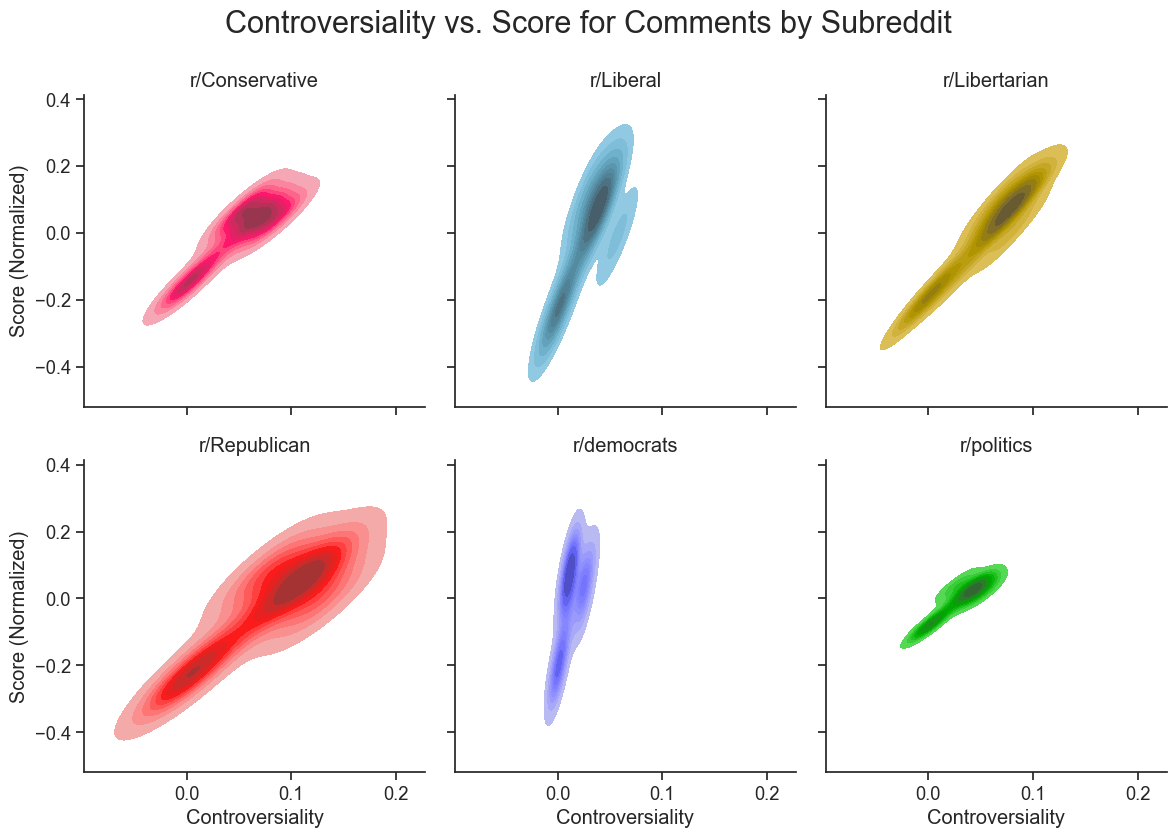

In [64]:
# Visualize controversiality vs. score for comments as density plots
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks', font_scale=1.2)

g = sns.FacetGrid(monthly_avg, col='name', col_wrap=3, height=4, hue='name', palette=color_map)

g.map(sns.kdeplot, 'avg_controversiality', 'avg_score', fill=True)
g.set_axis_labels('Controversiality', 'Score (Normalized)')
g.fig.suptitle('Controversiality vs. Score for Comments by Subreddit', y=1.05, fontsize=22)
g.set_titles('{col_name}')

plt.show()

# Save last figure to a file
g.savefig('controversiality_score_faceted.png')